In [19]:
%reload_ext autoreload
%autoreload 2
from pywinusb import hid
from lib.DMDpycrafter import DMDhid
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from lib.DMD import DmdDeviceHID

In [16]:
images=[]
img = np.asarray(PIL.Image.open("testimage.tif"))//129

h = (1600-1080)/2
w = (2560-1920)/2
img = np.pad(img, ((int(np.floor(h)), int(np.ceil(h))), (int(np.floor(w)), int(np.ceil(w)))), 'constant', constant_values=(0.5, 0.5))

images.append(img)

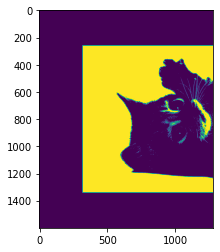

In [17]:
plt.imshow(img[:, :1280])

In [29]:
dmd = DMDhid()
dmd.stopsequence()
dmd.changemode(3)
exposure=[1000000]*30
dark_time=[0]*30
trigger_in=[False]*30
trigger_out=[1]*30
dmd.defsequence(images,exposure,trigger_in,dark_time,trigger_out,0)


merging...
encoding...
60580
85508
uploading...
0 121
100 121
0 170
100 170


In [30]:
dmd.startsequence()

In [25]:
hiddev = DmdDeviceHID()
hiddev.changemode(3)

exposure=[1000000]*len(images)
dark_time=[0]*len(images)
trigger_in=[False]*len(images)
trigger_out=[True]*len(images)

hiddev.defsequence(images,exposure,trigger_in,dark_time,trigger_out, 60)
# hiddev.startsequence()

merging...
encoding...
136884
Time for merging and encoding:  16.65203595161438
uploading...
0 272
100 272
200 272
Time for loading:  5.2409844398498535
Total time:  21.89501929283142


In [25]:
hiddev.startsequence()